# Requirements

In this section all requirements and package are installed and imported

In [1]:
%tensorflow_version 2.x
!nvidia-smi
%pip install -q transformers
%pip install -q seaborn

Tue Oct 26 19:54:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
import pandas as pd
from transformers import BertTokenizer
import matplotlib.pyplot as plt
import numpy as np
from transformers import TFBertModel
import datetime

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
!pip freeze > requirements.txt

# Getting data
Data is imported and fixed regarding to needs

In [4]:
# Method that remove special characters from columns
# (dataframe) df: Dataframe which will be cleared
# (string[]) cols: List of Columns' name
def remove_characters(df, cols):  
  df_tmp = df
  for c in cols:
    df_tmp[c] = df[c].str.replace("¿","")
  return df_tmp


def encode_dataset(tokenizer, text_sequences, max_length):
    token_ids = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
    for i, text_sequence in enumerate(text_sequences):
        encoded = tokenizer.encode(text_sequence)
        token_ids[i, 0:len(encoded)] = encoded
    attention_masks = (token_ids != 0).astype(np.int32)
    return {"input_ids": token_ids, "attention_masks": attention_masks}

def encode_token_labels(text_sequences, slot_names, tokenizer, slot_map, max_length):
    encoded = np.zeros(shape=(len(text_sequences), max_length), dtype=np.int32)
    for i, (text_sequence, word_labels) in enumerate(zip(text_sequences, slot_names)):
        encoded_labels = []
        for word, word_label in zip(text_sequence.split(), word_labels.split()):
            tokens = tokenizer.tokenize(word)
            encoded_labels.append(slot_map[word_label])
            expand_label = word_label.replace("B-", "I-")
            if not expand_label in slot_map:
                expand_label = word_label
            encoded_labels.extend([slot_map[expand_label]] * (len(tokens) - 1))
        encoded[i, 1:len(encoded_labels) + 1] = encoded_labels
    return encoded

In [5]:
# Global parameters
model_name = "bert-base-multilingual-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

# Loading data
train = pd.read_csv("07-train.csv", encoding = "utf-8-sig")
valid = pd.read_csv("07-test.csv", encoding = "utf-8-sig")

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [6]:
# Clear data
train = remove_characters(train,["words"])
valid = remove_characters(valid,["words"])

# Length of strings
train_sequence_lengths = [len(tokenizer.encode(text)) for text in train["words"]]
max_seq_len_t = max(train_sequence_lengths)

valid_sequence_lengths = [len(tokenizer.encode(text)) for text in valid["words"]]
max_seq_len_v = max(valid_sequence_lengths)

max_seq_len = max([max_seq_len_t,max_seq_len_v])

# Creating intents and slots categories
#intent_names = train["intent"].unique() 
intent_names = ['forecast_yield', 'forecast_precipitation', 'climatology', 'cultivars', 'places', 'forecast_date'] 
intent_map = dict((label, idx) for idx, label in enumerate(intent_names))
slot_names = ["[PAD]", "B-crop","B-cultivar","I-cultivar","B-locality","I-locality","B-measure","I-measure","B-date","I-date","B-unit","I-unit","O"]
slot_map = {}
for label in slot_names:
    slot_map[label] = len(slot_map)

# Encoding for intents
encoded_train = encode_dataset(tokenizer, train["words"], max_seq_len)
encoded_valid = encode_dataset(tokenizer, valid["words"], max_seq_len)
# Encoding for slots
slot_train = encode_token_labels(train["words"], train["labels"], tokenizer, slot_map, max_seq_len)
slot_valid = encode_token_labels(valid["words"], valid["labels"], tokenizer, slot_map, max_seq_len)
# Encoding intents
intent_train = train["intent"].map(intent_map).values
intent_valid = valid["intent"].map(intent_map).values
#
intent_train = train["intent"].map(intent_map).values
slot_train = encode_token_labels(train["words"], train["labels"], tokenizer, slot_map, max_seq_len)




['forecast_yield' 'forecast_precipitation' 'climatology' 'cultivars'
 'places' 'forecast_date']


# Descriptive analysis


Text(0.5, 1.0, 'Valid - max: 27')

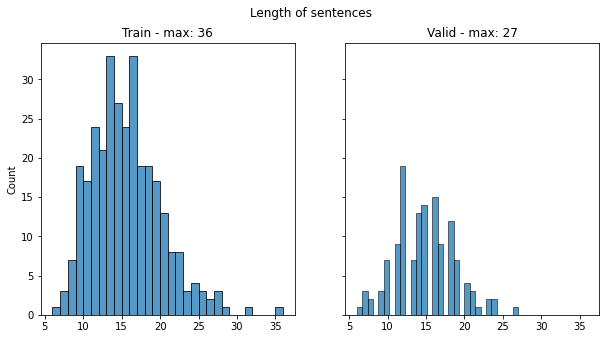

In [6]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
fig.suptitle('Length of sentences')

sns.histplot(train_sequence_lengths, bins=30, ax=axes[0])
axes[0].set_title(f"Train - max: {max_seq_len_t}")

sns.histplot(valid_sequence_lengths, bins=30, ax=axes[1])
axes[1].set_title(f"Valid - max: {max_seq_len_v}")

Text(0.5, 1.0, 'Valid')

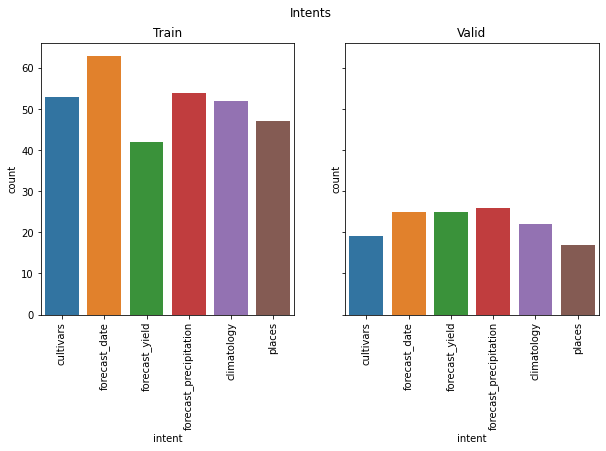

In [7]:
fig, axes = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10,5))
fig.suptitle('Intents')

sns.countplot(data=train, x="intent", ax=axes[0])
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_title("Train")

sns.countplot(data=valid, x="intent", ax=axes[1])
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_title("Valid")


# Modelling

In [9]:
def create_model(intent_num_labels, slot_num_labels):
  
  model_inputs =  keras.layers.Input(shape=(None,), dtype='int32', name='input_ids')
  #model_mask =  keras.layers.Input(shape=(None,), dtype='int32', name='attention_masks')
  
  bert = TFBertModel.from_pretrained(model_name).bert # get features
  #bert_output = bert([model_inputs,model_mask])    
  bert_output = bert(model_inputs)
  
    
  intents_drop = Dropout(rate=0.1, name="intent_dropout")(bert_output[1])  
  intents_fc = Dense(intent_num_labels, activation='softmax', name='intent_classifier')(intents_drop)
  
  slots_output = Dropout(rate=0.3, name='slots_dropout')(bert_output[0])
  #slots_output = Dense(500, activation='relu', name='slots_dense')(slots_output)  
  slots_output = Dense(slot_num_labels, activation='softmax', name='slots_classifier')(slots_output)

  #model = keras.Model(inputs=[model_inputs,model_mask], outputs=[slots_output, intents_fc])
  model = keras.Model(inputs=model_inputs, outputs=[slots_output, intents_fc])
  model.name = "DemeterBERT"
  #model.build(input_shape=[(None, max_seq_len),(None, max_seq_len)])
  model.build(input_shape=[(None, )])

  return model

In [10]:
# Hyper parameters
#opt = Adam()#learning_rate=3e-5, epsilon=1e-08)
opt = Adam(learning_rate=5e-5, epsilon=1e-08)
losses = [SparseCategoricalCrossentropy(from_logits=False),
          SparseCategoricalCrossentropy(from_logits=False)]
metrics = [SparseCategoricalAccuracy('accuracy')]

log_dir = "log/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")

In [11]:
model = create_model(intent_num_labels=len(intent_map), slot_num_labels=len(slot_map))
model.compile(optimizer=opt, loss=losses, metrics=metrics)

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [12]:
!rm -dfr log/
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir)
history = model.fit(    
    #x = [encoded_train["input_ids"],encoded_train["attention_masks"]],
    x = encoded_train["input_ids"],#encoded_train["attention_masks"]],
    y = (slot_train, intent_train),
    validation_split=0.2,
    batch_size=60,
    shuffle=True,
    epochs=40,
    callbacks=[tensorboard_callback]
    )

Epoch 1/40
5/5 [==============================] - 29s 2s/step - loss: 3.1859 - slots_classifier_loss: 1.3570 - intent_classifier_loss: 1.8289 - slots_classifier_accuracy: 0.6630 - intent_classifier_accuracy: 0.1532 - val_loss: 2.4791 - val_slots_classifier_loss: 0.4486 - val_intent_classifier_loss: 2.0306 - val_slots_classifier_accuracy: 0.8999 - val_intent_classifier_accuracy: 0.1111
Epoch 2/40
5/5 [==============================] - 4s 885ms/step - loss: 2.2790 - slots_classifier_loss: 0.4860 - intent_classifier_loss: 1.7930 - slots_classifier_accuracy: 0.8838 - intent_classifier_accuracy: 0.2379 - val_loss: 2.4816 - val_slots_classifier_loss: 0.3193 - val_intent_classifier_loss: 2.1623 - val_slots_classifier_accuracy: 0.9162 - val_intent_classifier_accuracy: 0.0794
Epoch 3/40
5/5 [==============================] - 4s 818ms/step - loss: 2.0679 - slots_classifier_loss: 0.4040 - intent_classifier_loss: 1.6639 - slots_classifier_accuracy: 0.8916 - intent_classifier_accuracy: 0.3266 - val

In [20]:
%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir log

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 373), started 2:00:01 ago. (Use '!kill 373' to kill it.)

<IPython.core.display.Javascript object>

# Evaluation

In [14]:
#train_e = model.evaluate([encoded_train["input_ids"],encoded_train["attention_masks"]], (slot_train, intent_train))
#test_e = model.evaluate([encoded_valid["input_ids"],encoded_valid["attention_masks"]], (slot_valid, intent_valid))
train_e = model.evaluate(encoded_train["input_ids"], (slot_train, intent_train))
test_e = model.evaluate(encoded_valid["input_ids"], (slot_valid, intent_valid))

5/5 [==============================] - 1s 154ms/step - loss: 0.9971 - slots_classifier_loss: 0.1278 - intent_classifier_loss: 0.8692 - slots_classifier_accuracy: 0.9712 - intent_classifier_accuracy: 0.8060


Text(0.5, 14.09375, 'Predicted label')

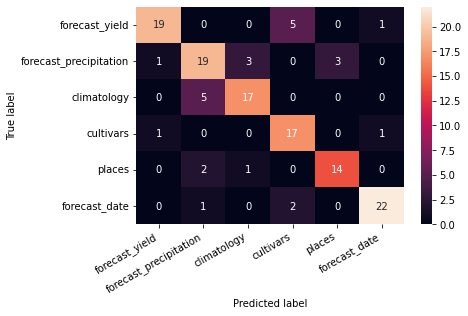

In [15]:
#y_pred = model.predict([encoded_valid["input_ids"], encoded_valid["attention_masks"]])
y_pred = model.predict(encoded_valid["input_ids"])
y_intent = y_pred[1].argmax(axis=-1)
cm = confusion_matrix(intent_valid, y_intent)
df_cm = pd.DataFrame(cm, index=intent_map, columns=intent_map)

hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Test

In [16]:
def decode_predictions(text, tokenizer, intent_names, slot_names,intent_id, slot_ids):
    info = {"intent": intent_names[intent_id]}
    collected_slots = {}
    active_slot_words = []
    active_slot_name = None
    for word in text.split():
        tokens = tokenizer.tokenize(word)
        current_word_slot_ids = slot_ids[:len(tokens)]
        slot_ids = slot_ids[len(tokens):]
        current_word_slot_name = slot_names[current_word_slot_ids[0]]
        if current_word_slot_name == "O":
            if active_slot_name:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = []
                active_slot_name = None
        else:
            # Naive BIO: handling: treat B- and I- the same...
            new_slot_name = current_word_slot_name[2:]
            if active_slot_name is None:
                active_slot_words.append(word)
                active_slot_name = new_slot_name
            elif new_slot_name == active_slot_name:
                active_slot_words.append(word)
            else:
                collected_slots[active_slot_name] = " ".join(active_slot_words)
                active_slot_words = [word]
                active_slot_name = new_slot_name
    if active_slot_name:
        collected_slots[active_slot_name] = " ".join(active_slot_words)
    info["slots"] = collected_slots
    return info

def nlu(text, tokenizer, my_model, intent_names, slot_names):
    inputs = tf.constant(tokenizer.encode(text))[None, :]  # batch_size = 1
    outputs = my_model(inputs)
    slot_logits, intent_logits = outputs
    #print(slot_logits.numpy())
    slot_ids = slot_logits.numpy().argmax(axis=-1)[0, 1:-1]
    #print(slot_ids)
    intent_id = intent_logits.numpy().argmax(axis=-1)[0]

    return decode_predictions(text, tokenizer, intent_names, slot_names,intent_id, slot_ids)

In [17]:
nlu("Cual es la mejor variedad para sembrar en Tolima",tokenizer, model, intent_names, slot_names)

{'intent': 'cultivars', 'slots': {'locality': 'Tolima'}}

# Export

In [18]:
!rm -dfr demeter

model.summary()
#model.save("demeter")
tf.keras.models.save_model(model,"demeter")

!zip -r demeter.zip demeter

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 177853440   input_ids[0][0]                  
__________________________________________________________________________________________________
slots_dropout (Dropout)         (None, None, 768)    0           bert[0][0]                       
__________________________________________________________________________________________________
intent_dropout (Dropout)        (None, 768)          0           bert[0][1]                       
______________________________________________________________________________________________

INFO:tensorflow:Assets written to: demeter/assets


INFO:tensorflow:Assets written to: demeter/assets
/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [19]:
model_loaded = tf.keras.models.load_model("demeter")
model_loaded.summary()
nlu("Cual es la mejor variedad para sembrar en Tolima",tokenizer, model_loaded, intent_names, slot_names)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 177853440   input_ids[0][0]                  
__________________________________________________________________________________________________
slots_dropout (Dropout)         (None, None, 768)    0           bert[0][0]                       
__________________________________________________________________________________________________
intent_dropout (Dropout)        (None, 768)          0           bert[0][1]                       
______________________________________________________________________________________________

{'intent': 'cultivars', 'slots': {'locality': 'Tolima'}}